In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
%matplotlib inline

In [4]:
print(nib.__version__, nilearn.__version__, nitime.__version__, scipy.__version__)

2.4.1 0.5.2 0.8.1 1.3.0


### Test the confounds file exists

In [ ]:
confounds_file = "/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_desc-confounds_regressors.tsv"

In [ ]:
confounds_df = pd.read_csv(confounds_file, sep=str('\t'), na_values="n/a")

In [ ]:
confounds_df.head()

In [ ]:
poss_confounds = list(confounds_df.columns)
poss_confounds[:5]

### Define paths etc

In [1]:
sub = "AV"
ses = "20111117"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/sub-AV/")
derivs_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/derivatives/')
out_dir = os.path.join(derivs_dir, 'streams')
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
ref_vol_name = "ref_vol"
mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_mask.nii.gz")
coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-coherence_map.nii")

#mypreproc_bids_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117/")
#fmriprep_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/")


NameError: name 'os' is not defined

#### For testing BIDS names

In [ ]:
utils.isBIDSFile(mask_file)
utils.isBIDSFile(coh_fn)
utils.isBIDSFile("sub-AV_ses-20111117_desc-lgnROI1p20v0M_roi.nii.gz")

#### Make ref_vol from first dicom

In [ ]:
first_dicom = "/Users/smerdis/data/LGN/AV_20111117_session/AV_20111117/AV_20111117_dicom/epi01_hemi/IM-0005-0001.dcm"

In [ ]:
!ls {first_dicom}

In [ ]:
!pwd

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {ref_vol_name} -z n -o {out_dir} {first_dicom}"
print(dcm2niix_cmd)
#os.system(dcm2niix_cmd)

#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [ ]:
from bids import BIDSLayout
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
raw_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses, suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [ ]:
ref_vol_path = os.path.join(out_dir, ref_vol_name)
for this_epi in raw_bolds:
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(-1, 'desc-preproc')
    epi_stub_mcf = '_'.join(epi_stub_parts)
    mcflirt_cmd = f"mcflirt -reffile {ref_vol_path} -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {os.path.join(out_dir, epi_stub_mcf)}"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

#### Move event and json files

In [ ]:
events_glob = f"{mypreproc_bids_dir}/sub-{sub}/ses-{ses}/func/*events.tsv"
task_json_glob = f"{mypreproc_bids_dir}/sub-{sub}/ses-{ses}/func/*task*json"
print(glob.glob(task_json_glob), sep="\n")

In [ ]:
for e in glob.glob(events_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    shutil.copyfile(e, new_file_name)

In [ ]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    shutil.copyfile(e, new_file_name)

### Fix the event files

For this subject, I consulted the scan log to line up the scans to runs and moved the files around manually

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1, 2, 3, 4]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    with open(events_fn, 'w') as f:
        f.write(events_file_contents)
    #print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Only run one of the next two cells! (Picks which task and runs to analyze)

#### Hemifield

In [6]:
task = "hemi"
runs = [1, 2]
#space="T1w"

#### MP

In [ ]:
task = "mp"
runs = [1, 2, 3, 4, 5, 6, 7, 8]
space="T1w"

### Use BIDSLayout to get files that would be passed to workflow

In [7]:
from bids import BIDSLayout

In [8]:
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)

In [9]:
preproc_layout = BIDSLayout(out_dir, validate=False)

In [10]:
bolds = sorted(preproc_layout.get(subject=sub, session=ses, task=task, extension=['nii.gz'],
                           desc="preproc", return_type='file'))
print(bolds)

['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/derivatives/streams/sub-AV_ses-20111117_task-hemi_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/derivatives/streams/sub-AV_ses-20111117_task-hemi_run-02_desc-preproc_bold.nii.gz']


In [11]:
#masks = sorted([f for f in preproc_layout.get(subject=sub, suffix='mask',
#            session=ses, run=[], extension=['nii.gz'], return_type='file')])

masks = [mask_file]*2

In [12]:
masks

['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/derivatives/streams/sub-AV_ses-20111117_mask.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/derivatives/streams/sub-AV_ses-20111117_mask.nii.gz']

In [13]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task=task, session=ses, run=runs, extension=['nii.gz'], return_type='file')

In [14]:
raw_bolds

['/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-01_bold.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/AV_20111117_fromdicom/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-02_bold.nii.gz']

In [15]:
raw_layout.get_tr(raw_bolds[0])

2.25

In [16]:
TRs = [raw_layout.get_tr(f) for f in raw_bolds]

In [17]:
print(TRs)
assert TRs.count(TRs[0])==len(TRs)

[2.25, 2.25]


### Use the actual utils.py function

In [ ]:
bolds, masks, eventfiles, TR, confounds = utils.get_files_fmriprep14(sub, ses, task,
    raw_data_dir, fmriprep_dir, run=runs)

In [ ]:
# runs is a list containing the fmriprep run numbers we want to analyze
# so run is the fmriprep run number, and run_idx is its position in runs
run = 2
if run not in runs:
    print('Error, that run is not present for this task!')
else:
    run_idx = runs.index(run)
    bold_file = bolds[run_idx]
    mask_file = masks[run_idx]
    print(run, bold_file, mask_file, sep="\n")

### Just load the files directly

In [ ]:
anat_file = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}", 'anat', f"sub-{sub}_desc-preproc_T1w.nii.gz")
#func = os.path.join(fmriprep_dir, bolds[0])
#mROI = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_lLGN_roi_manual.nii.gz")

In [ ]:
# nipype_dir = f"{out_dir}/nipype_AV_20111117_mp_2019-11-26_20-26-54" #mp (update each time glm is run)
# nipype_dir = f"{out_dir}/nipype_AV_20111117_hemi_2019-11-26_21-06-50" #hemi (update each time glm is run)
nipype_dir = f"{out_dir}/nipype_AV_20111117_{task}_rdpreproc_noconfounds"
wf_dir = f"{nipype_dir}/{task}/modelfit"
datasink_dir = os.path.join(wf_dir, 'datasink')
print(datasink_dir)

In [ ]:
hemi_command = f"python glm_hemi_AV20111117_rdpreproc.py {raw_data_dir} \
{out_dir} {sub} {ses} hemi None {nipype_dir} \"[1, 2]\""
mp_command = f"python glm_mp_AV20111117.py {raw_data_dir} \
{out_dir} {sub} {ses} mp {space} {nipype_dir} \"{runs}\""
print(hemi_command)
print(mp_command)

In [ ]:
!ls "{datasink_dir}"

In [ ]:
!ls "{datasink_dir}/results_dir"

### Filenames of other maps etc we want to overlay on our images

In [ ]:
coh_fn = f"{out_dir}/nitime/sub-{sub}_ses-{ses}_task-hemi_run-02_desc-coherence_map.nii"
print(coh_fn)
!ls {coh_fn}

In [ ]:
# from fsleyes 0.32
def isBIDSFile(filename, strict=True):
    """Returns ``True`` if ``filename`` looks like a BIDS image or JSON file.

    :arg filename: Name of file to check
    :arg strict:   If ``True`` (the default), the file must be within a BIDS
                   dataset directory, as defined by :func:`inBIDSDir`.
    """

    name    = os.path.basename(filename)
    pattern = r'([a-z0-9]+-[a-z0-9]+_)*([a-z0-9])+\.(nii|nii\.gz|json)'
    flags   = re.ASCII | re.IGNORECASE
    match   = re.fullmatch(pattern, name, flags) is not None
    
    print(name, match)

    return ((not strict) or inBIDSDir(filename)) and match

In [ ]:
isBIDSFile(coh_fn)

### View the contrast beta maps overlaid on the functional and anatomical images

In [ ]:
contrasts = utils.get_contrasts(task)

In [ ]:
contrasts

In [ ]:
contrast_idx = 2 # position in the list of contrasts (zero-indexed)
contrast = contrast_idx + 1 # suffix number of the level 1 COPE file for that contrast
l1copes, l2copes = utils.get_model_outputs(datasink_dir, [contrast])

In [ ]:
l1copes

In [ ]:
l2copes

In [ ]:
utils.view_results(datasink_dir, [contrast], anat_file, bold_file)

In [ ]:
print(f"{utils.view_results(datasink_dir, [3], anat_file, bold_file)} {coh_fn}") # R-L

### View these files using nilearn tools

#### First establish some coordinates to view at

In [ ]:
# cut in x-direction
sagittal = 43
# cut in y-direction
coronal = 27
# cut in z-direction
axial = -2

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]

#### Now begin plotting

In [ ]:
mean_bold = mean_img(bold_file)
plot_epi(mean_bold, title=f"Mean of BOLD run {run} of task {task}", cut_coords=cut_coords)

In [ ]:
plot_roi(mask_file, mean_bold, title=f"Brainmask of BOLD run {run} of task {task}")

In [ ]:
for l1cope in l1copes:
    plot_stat_map(l1cope, mean_bold,
        title=f"Level 1 COPE for contrast {contrast} of task {task}",
        threshold=10, cut_coords=cut_coords, colorbar=True)

In [ ]:
plot_stat_map(l2copes[0], mean_bold,
    title=f"Level 2 COPE for contrast {contrast} of task {task}",
    threshold=10, cut_coords=[2, -5, -2])

### LGN region drawing/manipulation!

In [ ]:
manual_roi = f"{out_dir}/sub-NB_R-LGN_mask_manual.nii.gz"

In [ ]:
plot_roi(manual_roi, mean_bold, title=f"Manual LGN mask")

In [ ]:
r_lgn_mask_manual = load_img(manual_roi).get_data().astype(bool)
r_lgn_mask_manual.shape

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [ ]:
img = nib.load(bold_file)

In [ ]:
print(img.header)

In [ ]:
img_data = img.get_fdata()

In [ ]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [ ]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [ ]:
n_timepoints = img.shape[-1]

In [ ]:
print(nvox, n_timepoints)

In [ ]:
img_flat = np.reshape(img_data, (nvox, -1))

In [ ]:
img_flat[:10, 0]

In [ ]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

In [ ]:
2.25*139

### Begin coherence analysis in nitime

In [18]:
#run = 2
if TRs:
    TR = TRs[0]
else:
    TR = 2.25
#bold_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-{run:02d}_desc-preproc_bold.nii.gz"

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

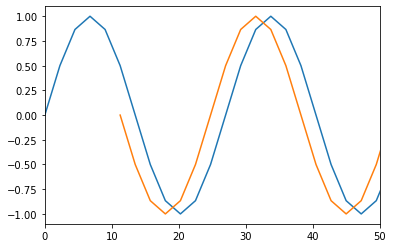

In [19]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds
Fs = 1/TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nperseg = n_trs_func - trs_exc_beg - trs_exc_end

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, TR)
t_trim = np.arange((trs_exc_beg-1)*TR, (total_len - trs_exc_beg - trs_exc_end)+1, TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

#### average the runs

In [20]:
masker = NiftiMasker(detrend=False, standardize="psc", mask_strategy="epi", high_pass=f_lb, low_pass=f_ub, t_r=TR) # 

In [21]:
masker.fit(bolds[0])

NiftiMasker(detrend=False, dtype=None, high_pass=0.02, low_pass=0.15,
            mask_args=None, mask_img=None, mask_strategy='epi',
            memory=Memory(location=None), memory_level=1, sample_mask=None,
            sessions=None, smoothing_fwhm=None, standardize='psc', t_r=2.25,
            target_affine=None, target_shape=None, verbose=0)

In [22]:
masker.mask_img_.to_filename(mask_file)

In [23]:
mask_img = masker.mask_img_
mask_img.shape

(128, 128, 21)

In [24]:
mean_bold_timeseries = utils.average_timeseries(bolds, masker)

0
(139, 99099, 2)
(139, 99099)
float32
[[ 5.7427e-02  4.2455e-03 -8.0480e-03 -8.8931e-03 -1.3106e-03]
 [-2.8243e+00  1.0569e+00  8.6659e-01 -5.6039e-01  8.0705e-01]
 [-1.8055e-01  1.2226e+00 -1.4402e+00 -5.5192e-03 -1.7263e-01]
 [ 2.9853e-01  7.1439e-01 -1.3277e+00  6.7925e-01 -2.0244e+00]
 [-1.9440e+00  6.8931e-01  5.9039e-01 -2.4671e-01 -1.5959e+00]]
1
(139, 99099, 2)
(139, 99099)
float32
[[-0.0183 -0.0123  0.0253 -0.0222  0.0468]
 [ 0.4857 -0.7232 -1.2435  0.1972 -1.1115]
 [-0.347   1.7495 -0.3545 -0.9387 -0.6077]
 [-0.7999  2.5231  0.6939 -1.4814  0.8707]
 [-0.2418  0.7038  0.9917 -0.182   0.7338]]


In [25]:
mean_bold_timeseries.shape

(139, 99099)

In [26]:
mean_bold_timeseries[:5, :5]

array([[ 0.0195, -0.004 ,  0.0086, -0.0156,  0.0228],
       [-1.1693,  0.1669, -0.1884, -0.1816, -0.1522],
       [-0.2638,  1.486 , -0.8973, -0.4721, -0.3902],
       [-0.2507,  1.6187, -0.3169, -0.4011, -0.5768],
       [-1.0929,  0.6965,  0.791 , -0.2144, -0.431 ]])

In [27]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=TR)

In [28]:
hemi_ts.shape, hemi_ts_trim.shape

((139,), (132,))

In [29]:
mean_bold_timeseries.shape

(139, 99099)

In [30]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

(132, 99099)

### begin coherence stuff

#### dummy stuff to see how coherence works

In [ ]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

In [ ]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

#### analyze the real fmri data

In [31]:
masked_ts_flat = trim_bold_nm.T # want nvox, n_tp so transpose NiftiMasker result
#demean_ts_flat = demean.T

[ 11.25  13.5   15.75  18.    20.25  22.5   24.75  27.    29.25  31.5
  33.75  36.    38.25  40.5   42.75  45.    47.25  49.5   51.75  54.
  56.25  58.5   60.75  63.    65.25  67.5   69.75  72.    74.25  76.5
  78.75  81.    83.25  85.5   87.75  90.    92.25  94.5   96.75  99.
 101.25 103.5  105.75 108.   110.25 112.5  114.75 117.   119.25 121.5
 123.75 126.   128.25 130.5  132.75 135.   137.25 139.5  141.75 144.
 146.25 148.5  150.75 153.   155.25 157.5  159.75 162.   164.25 166.5
 168.75 171.   173.25 175.5  177.75 180.   182.25 184.5  186.75 189.
 191.25 193.5  195.75 198.   200.25 202.5  204.75 207.   209.25 211.5
 213.75 216.   218.25 220.5  222.75 225.   227.25 229.5  231.75 234.
 236.25 238.5  240.75 243.   245.25 247.5  249.75 252.   254.25 256.5
 258.75 261.   263.25 265.5  267.75 270.   272.25 274.5  276.75 279.
 281.25 283.5  285.75 288.   290.25 292.5  294.75 297.   299.25 301.5
 303.75 306.  ]


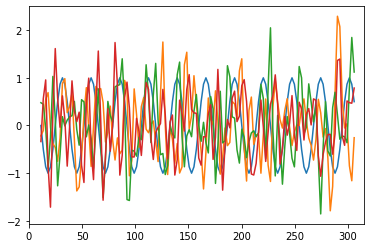

In [32]:
t=t_trim
print(t)
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.plot(t, hemi_alt_trim)
ax.plot(t, masked_ts_flat[32, :])
ax.plot(t, masked_ts_flat[3222, :])
ax.plot(t, masked_ts_flat[11513, :])
#ax.plot(t, masked_ts_flat[546434, :])

#### SpectralAnalyzer

In [33]:
bold_flat = ts.TimeSeries(masked_ts_flat[:, :], sampling_interval=TR)
#bold_flat = ts.TimeSeries(demean_ts_flat[:, :], sampling_interval=TR)

In [34]:
bold_flat.sampling_rate

0.4444444444444444 Hz

In [35]:
bold_flat.shape

(99099, 132)

In [36]:
assert(nperseg == masked_ts_flat.shape[-1])

In [37]:
S_original = nta.SpectralAnalyzer(bold_flat, method={'this_method':'welch', 'NFFT':nperseg, 'Fs':bold_flat.sampling_rate})

In [38]:
print(S_original)

SpectralAnalyzer(method={'this_method': 'welch', 'NFFT': 132, 'Fs': 0.4444444444444444 Hz}, BW=None, adaptive=False, low_bias=False)


In [39]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.plot(S_original.psd[0],
              S_original.psd[1][voxid],
              label='Welch PSD')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]))

    ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
    
    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [40]:
voxid = 144

[0.     0.0034 0.0067 0.0101 0.0135 0.0168 0.0202 0.0236 0.0269 0.0303
 0.0337 0.037  0.0404 0.0438 0.0471 0.0505 0.0539 0.0572 0.0606 0.064
 0.0673 0.0707 0.0741 0.0774 0.0808 0.0842 0.0875 0.0909 0.0943 0.0976
 0.101  0.1044 0.1077 0.1111 0.1145 0.1178 0.1212 0.1246 0.1279 0.1313
 0.1347 0.138  0.1414 0.1448 0.1481 0.1515 0.1549 0.1582 0.1616 0.165
 0.1684 0.1717 0.1751 0.1785 0.1818 0.1852 0.1886 0.1919 0.1953 0.1987
 0.202  0.2054 0.2088 0.2121 0.2155 0.2189 0.2222] [[3.1997e-03 1.9258e-03 1.9537e-05 ... 9.1880e-09 8.2255e-09 3.9478e-09]
 [1.2905e-01 6.6879e-02 6.5231e-05 ... 2.7254e-08 2.4701e-08 1.1921e-08]
 [1.7300e-02 7.5853e-03 9.4438e-05 ... 3.2550e-10 2.3816e-10 1.0438e-10]
 ...
 [7.5860e-04 1.7728e-04 6.6541e-05 ... 2.4870e-09 1.8531e-09 8.2216e-10]
 [1.8438e-01 9.5167e-02 2.0028e-06 ... 5.7075e-09 5.6353e-09 2.7987e-09]
 [1.1013e-01 5.5639e-02 2.8843e-05 ... 3.0051e-10 2.7822e-10 1.3579e-10]] 99099


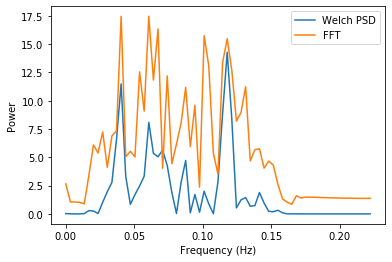

In [41]:
plot_spectra(S_original, voxid)

In [42]:
masked_ts_flat.shape

(99099, 132)

In [43]:
bold_flat.data.shape

(99099, 132)

In [44]:
def comparison_plots(masked_ts_flat, S_original, Fs, nperseg, voxid=1000):
    # Compute PSD with `scipy.signal.welch`
    f_welch, S_welch = scipy.signal.welch(
        masked_ts_flat[voxid, :], fs=Fs, nperseg=nperseg, noverlap=(nperseg // 2),
        detrend=None, scaling='density', window='hanning')

    # Compute PSD with `matplotlib.mlab.psd`, using parameters that are
    # *equivalent* to those used in `scipy.signal.welch` above
    S_mlab, f_mlab = mlab.psd(
        masked_ts_flat[voxid, :], Fs=Fs, NFFT=nperseg, noverlap=(nperseg // 2),
        detrend=None, scale_by_freq=True, window=mlab.window_hanning)

    fig, axes = plt.subplots(3, 1, sharex=True)

    # Plot PSD computed via both methods
    axes[0].plot(f_welch, S_welch, label='scipy.signal.welch')
    axes[0].plot(f_mlab, S_mlab, label='mlab.psd')
    axes[0].set_ylabel('PSD')
    axes[0].legend()

    axes[1].plot(S_original.spectrum_fourier[0],
                  np.abs(S_original.spectrum_fourier[1][voxid]),
                  label='nitime FFT')

    freqs2 = nitime.utils.get_freqs(Fs, masked_ts_flat.shape[-1])
    fft = scipy.fftpack.fft(bold_flat.data)
    scaledAmp = np.abs(fft[:, :freqs2.shape[0]])
    amp = 2*scaledAmp/masked_ts_flat.shape[-1]
    sqrtsummagsq = np.sqrt(np.sum(scaledAmp[:, :]**2))
    print(sqrtsummagsq)
    co = scaledAmp[:,11]/sqrtsummagsq;

    axes[1].plot(freqs2, scaledAmp[voxid], label='ScaledAmp')
    axes[2].plot(freqs2, amp[voxid], label='Amp')
    axes[2].set_xlabel('f')
    axes[1].legend()
    axes[2].legend()

    plt.suptitle(f"voxid {voxid}, co {co[voxid]}")
    plt.show()
    
    return [freqs2, amp, co]

20798.82307998623


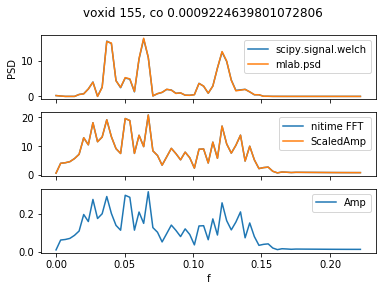

20798.82307998623


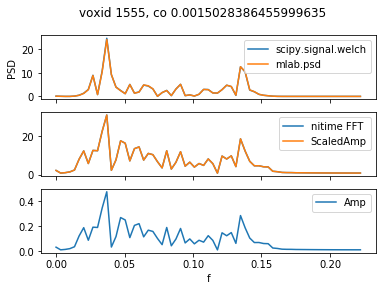

20798.82307998623


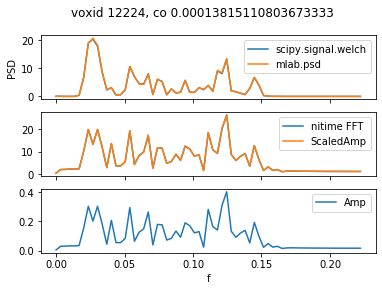

In [45]:
for v in [155, 1555, 12224]:
    _ = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, v)

20798.82307998623


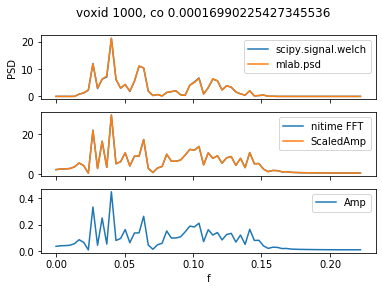

In [46]:
[f, a, co] = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, 1000)

(array([37822., 42068., 11329.,  2661.,  1419.,  1096.,   939.,   816.,
          630.,   319.]),
 array([1.8313e-06, 4.2738e-04, 8.5293e-04, 1.2785e-03, 1.7040e-03,
        2.1296e-03, 2.5551e-03, 2.9807e-03, 3.4062e-03, 3.8318e-03,
        4.2573e-03]),
 <a list of 10 Patch objects>)

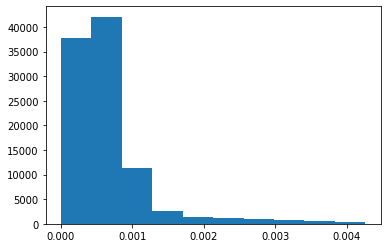

In [47]:
plt.hist(co)

In [48]:
coh_amp_map = masker.inverse_transform(co)

In [ ]:
coh_amp_map.to_filename(coh_fn)

#### Correlation and Coherence

In [ ]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[:1000,:]))

In [ ]:
full_stim.shape

In [ ]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

In [ ]:
cr1 = nta.CorrelationAnalyzer(test_ts)
print(cr1.corrcoef)
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [ ]:
ch1 = nta.CoherenceAnalyzer(test_ts)
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)
coh

In [ ]:
fig03 = ntv.drawmatrix_channels(coh)

In [ ]:
ch1.phase[0,1]

#### SeedCoherenceAnalyzer

In [ ]:
n_seeds = 1
A = nta.SeedCoherenceAnalyzer(hemi_ts_trim, bold_flat, method=dict(NFFT=132))
B = nta.SeedCorrelationAnalyzer(hemi_ts_trim, bold_flat)
#freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]
freq_idx_hemionly = np.where((np.isclose(A.frequencies, hemi_freq)))[0]
#print(freq_idx, freq_idx_hemionly)
print(A.frequencies, A.frequencies[freq_idx_hemionly], sep="\n")
cor = []
coh = []

for this_seed in range(n_seeds):
    #print(this_seed, A.coherence[this_seed], A.coherence[this_seed][freq_idx])
    # Extract the coherence and average across these frequency bands:
    print(A.coherence.shape, A.coherence[:, :], A.coherence[:, freq_idx_hemionly], sep="\n")
    coh.append(np.mean(A.coherence[:, freq_idx_hemionly], -1))  # Averaging on the last dimension
    cor.append(B.corrcoef[this_seed])  # No need to do any additional computation
        
print(coh, cor, sep="\n")

In [ ]:
len(coh[0])

In [ ]:
np.count_nonzero(coh[0])

#### Write coherence values to Nifti file

In [ ]:
coherence_img = masker.inverse_transform(coh[0])
coherence_img.shape

In [ ]:
print(coh_fn)

In [ ]:
coherence_img.to_filename(coh_fn)

In [ ]:
!ls "{coh_fn}"

In [ ]:
cmd = f"fsleyes {bolds[0]} {coh_fn}"

In [ ]:
os.system(cmd)

#### Some visualizations

In [ ]:
plt.hist(coh[0])

In [ ]:
plt.boxplot(coh[0])

In [ ]:
np.count_nonzero(coh[0]==0)

### Continue from here...

In [ ]:
lgn_coh_low = 0.17
lgn_coh_high = 0.19
lgn_voxel_mask_coh = np.logical_and((coh[0] > lgn_coh_low), (coh[0] < lgn_coh_high))

In [ ]:
np.count_nonzero(lgn_voxel_mask_coh)

## Assigning voxels within an ROI to M/P

In [ ]:
copefile = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_mp/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'
ROIfile = mROI

In [ ]:
def assign_mp_command(cope, roimask, pct_thresh, roi_below, roi_above, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(roimask)
    print(f"python assign_mp.py {cope} {roimask} {pct_thresh} {roi_below} {roi_above} {out_dir}")

def assign_voxels(infile, rois, split_pct):
    """Assign voxels to an ROI based on the percentile of intensity they fall in.
    
    rois should be a list of length 2, split_pcts should be a list of length 1
    
    e.g. assign_voxels_percentile(infile, ['M', 'P'], 80)"""
    from nipype.interfaces.fsl import ImageMaths
    stats = ImageMaths()
    stats.inputs.in_file = infile
    stats.inputs.op_string = f"-thr {split_pct} -bin {roi_above}"
    print(stats.cmdline)

In [ ]:
assign_mp_command(copefile, ROIfile, 80, 'M', 'P')

In [ ]:
masked_cope = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_hemi/hemifield/modelfit/datasink/cope_masked.nii.gz'

In [ ]:
assign_voxels_percentile(masked_cope, ['M', 'P'], 80)